In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv, SAGEConv, CGConv, GMMConv
from tqdm import tqdm
import torch.optim as optim

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

In [2]:
os.getcwd()
use_cuda_if_available = False
BATCH_SIZE = 50
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    
seed = 7498
set_seed(seed)

# Importing the Main tabular data

In [4]:
signal = pd.read_csv('/teamspace/studios/this_studio/Preprocessing Eflow Images/data/dataset3/sig_btagged2jets.txt', sep = '\t')
background = pd.read_csv('/teamspace/studios/this_studio/Preprocessing Eflow Images/data/dataset3/bg_btagged2jets.txt', sep = '\t')

In [5]:
signal.head()

,eventno,jetmultiplicity,axion_Eta,axion_Phi,axion_pT,axion_Px,axion_Py,axion_Pz,axion_E,Z_Eta,...,isophoton_Pz,isophoton_E,jet1_btag,jet2_btag,jet3_btag,jet4_btag,invmass_2j1p,delta_eta_jet1_jet2,delta_phi_jet1_jet2,deltaR_jet1_jet2
0,228,2,-0.034237,-0.864124,44.4921,28.8890,-33.8375,-1.52359,63.3008,0.626346,...,8.15751,38.6899,1,1,0,0,90.217625,0.100643,1.524951,1.528268
1,436,2,1.385930,0.331321,34.5022,32.6258,11.2233,64.66500,85.9530,4.751210,...,43.61580,55.1083,1,1,0,0,86.379330,0.611792,-1.761031,1.864275
2,541,2,-0.961386,-0.893333,31.1332,19.5149,-24.2579,-34.75960,64.8188,-2.760710,...,-51.77440,63.3654,1,1,0,0,104.956134,-0.172527,1.894769,1.902607
3,697,2,-0.682404,-2.496180,35.2896,-28.1911,-21.2278,-25.99480,62.8182,-2.181670,...,-76.57120,77.9121,1,1,0,0,89.161722,-0.891442,1.682195,1.903799
4,1344,2,2.551010,-2.732630,31.3965,-28.8073,-12.4849,200.02700,207.4140,3.803630,...,34.83620,45.8901,1,1,0,0,96.848533,-0.397550,1.805895,1.849136


In [6]:
signal.columns

Index(['eventno', 'jetmultiplicity', 'axion_Eta', 'axion_Phi', 'axion_pT',
       'axion_Px', 'axion_Py', 'axion_Pz', 'axion_E', 'Z_Eta', 'Z_Phi', 'Z_pT',
       'Z_Px', 'Z_Py', 'Z_Pz', 'Z_E', 'highb_Eta', 'highb_Phi', 'highb_pT',
       'highb_Px', 'highb_Py', 'highb_Pz', 'highb_E', 'lowb_Eta', 'lowb_Phi',
       'lowb_pT', 'lowb_Px', 'lowb_Py', 'lowb_Pz', 'lowb_E', 'genphoton_Eta',
       'genphoton_Phi', 'genphoton_pT', 'genphoton_Px', 'genphoton_Py',
       'genphoton_Pz', 'genphoton_E', 'jet1_Eta', 'jet1_Phi', 'jet1_pT',
       'jet1_Px', 'jet1_Py', 'jet1_Pz', 'jet1_E', 'jet2_Eta', 'jet2_Phi',
       'jet2_pT', 'jet2_Px', 'jet2_Py', 'jet2_Pz', 'jet2_E', 'jet3_Eta',
       'jet3_Phi', 'jet3_pT', 'jet3_Px', 'jet3_Py', 'jet3_Pz', 'jet3_E',
       'jet4_Eta', 'jet4_Phi', 'jet4_pT', 'jet4_Px', 'jet4_Py', 'jet4_Pz',
       'jet4_E', 'isophoton_Eta', 'isophoton_Phi', 'isophoton_pT',
       'isophoton_Px', 'isophoton_Py', 'isophoton_Pz', 'isophoton_E',
       'jet1_btag', 'jet2_btag', 'je

In [7]:
#Adding Labels in the DataFrame
signal['label'] = 1
background['label'] = 0

# Plan for defining the Graph

Individual Event -> Graph -> Fully Connected Graph, Undirectional

Objects(Isophoton, jet1, jet2) -> Nodes

Node Lable -> (isophoton, jet1, jet2, jet3, jet4) -> (0,1,2,3,4)

Node Features -> (Eta, Phi, pT, E)

Edge Index -> ((0, 0, 0, 0, 1, 1, 1, 2, 2, 3)
                (1, 2, 3, 4, 2, 3, 4, 3, 4, 4))

Edge Features -> $\Delta R$ between the ((0,1), (0,2), (0,3), (0,4), (1,2), (1,3), (1, 4), (2,3), (2,4), (3,4))

Graph Features -> (jet_multiplicity, inv_mass)

Graph Lable -> 0:Background, 1:Signal

# Aggregating Node Features

In [8]:
def get_node_features(x:pd.DataFrame) -> list:
    """
    Extracts node features for isophoton, jet1, and jet2 from a DataFrame
    and returns a list of node features for all events.

    Parameters:
    -----------
    x : pd.DataFrame
        Input DataFrame with columns containing features for each object in the event.

    Returns:
    --------
    list_of_node_features : list of lists
        Each element in the list is a 2D list of shape (3, num_features) 
        containing node features for isophoton, jet1, and jet2.
    """
    # List to store node features for all events (graphs)
    list_of_node_features = []

    # Columns for each object's features
    isophoton_cols = ['isophoton_Eta', 'isophoton_Phi', 'isophoton_pT', 'isophoton_E']
    jet1_cols = ['jet1_Eta', 'jet1_Phi', 'jet1_pT', 'jet1_E']
    jet2_cols = ['jet2_Eta', 'jet2_Phi', 'jet2_pT', 'jet2_E']
    jet3_cols = ['jet3_Eta', 'jet3_Phi', 'jet3_pT', 'jet3_E']
    jet4_cols = ['jet4_Eta', 'jet4_Phi', 'jet4_pT', 'jet4_E']

    for _, event in x.iterrows():
        isophoton_features = event[isophoton_cols].values.tolist()  
        jet1_features = event[jet1_cols].values.tolist()
        jet2_features = event[jet2_cols].values.tolist()            
        jet3_features = event[jet3_cols].values.tolist()            
        jet4_features = event[jet4_cols].values.tolist() 

        event_node_features = [isophoton_features, jet1_features, jet2_features, jet3_features, jet4_features]

        list_of_node_features.append(event_node_features)

    return list_of_node_features

In [9]:
signal_node_features_list = get_node_features(signal)
background_node_features_list = get_node_features(background)

In [10]:
# Shape of node_features_list
print(len(signal_node_features_list))           # Number of events (graphs)
print(len(signal_node_features_list[0]))        # Number of nodes (5: isophoton, jet1, jet2, jet3, jet4)
print(len(signal_node_features_list[0][0]))     # Number of features per node

886
5
4


In [11]:
# Shape of node_features_list
print(len(background_node_features_list))           # Number of events (graphs)
print(len(background_node_features_list[0]))        # Number of nodes (3: isophoton, jet1, jet2, jet3, jet4)
print(len(background_node_features_list[0][0]))     # Number of features per node

1529
5
4


In [12]:
signal_node_features_list[0] #Each Row represents node feature

[[0.214053, 2.49454, 37.8202, 38.6899],
 [-0.0143928, -0.208869, 28.6807, 28.6837],
 [-0.115036, -1.73382, 23.2269, 23.3808],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0]]

# Aggregating Edge Index and Edge Features

In [13]:
edge_index = [[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
               [1, 2, 3, 4, 2, 3, 4, 3, 4, 4]]  

from helper_function_module import Euclidean_distance as ed
def get_edge_features(x:pd.DataFrame) -> list:
    """
    Extracts edge features(deltaR) between isophoton, jet1, and jet2 from a DataFrame
    and returns a list of edge features for all events.

    Parameters:
    -----------
    x : pd.DataFrame
        Input DataFrame with columns containing features for each object in the event.

    Returns:
    --------
    list_of_edge_features : list of lists
        Each element in the list is a 1D list of size 3 
        containing edge features for isophoton, jet1, and jet2.
    """

    list_of_edge_features = []

    for _, event in x.iterrows():
        isophoton_EtaPhi = event[['isophoton_Eta', 'isophoton_Phi']].values
        jet1_EtaPhi = event[['jet1_Eta', 'jet1_Phi']].values
        jet2_EtaPhi = event[['jet2_Eta', 'jet2_Phi']].values
        jet3_EtaPhi = event[['jet3_Eta', 'jet3_Phi']].values
        jet4_EtaPhi = event[['jet4_Eta', 'jet4_Phi']].values
        
        edge_01 = ed(isophoton_EtaPhi, jet1_EtaPhi)
        edge_02 = ed(isophoton_EtaPhi, jet2_EtaPhi)
        edge_03 = ed(isophoton_EtaPhi, jet3_EtaPhi)
        edge_04 = ed(isophoton_EtaPhi, jet4_EtaPhi)

        edge_12 = ed(jet1_EtaPhi, jet2_EtaPhi)
        edge_13 = ed(jet1_EtaPhi, jet3_EtaPhi)
        edge_14 = ed(jet1_EtaPhi, jet4_EtaPhi)

        edge_23 = ed(jet2_EtaPhi, jet3_EtaPhi)
        edge_24 = ed(jet2_EtaPhi, jet4_EtaPhi)

        edge_34 = ed(jet3_EtaPhi, jet4_EtaPhi)
        
        
        list_of_edge_features.append([edge_01, edge_02, edge_03, edge_04, edge_12, 
                                      edge_13, edge_14, edge_23, edge_24, edge_34])
    return list_of_edge_features

In [14]:
signal_edge_features_list = get_edge_features(signal)
background_edge_features_list = get_edge_features(background)

In [15]:
print(len(signal_edge_features_list))
print(len(signal_edge_features_list[0]))

886
10


In [16]:
signal_edge_features_list[0]

[2.713043992422283,
 2.0810109593528523,
 2.5037069513840873,
 2.5037069513840873,
 1.5282684993505689,
 0.20936430415149568,
 0.20936430415149568,
 1.737632030579547,
 1.737632030579547,
 0.0]

In [17]:
print(len(background_edge_features_list))
print(len(background_edge_features_list[0]))

1529
10


# Aggregating Data for Graphs

In [18]:
def get_graph_features(node_features_list:list, edge_features_list:list, edge_index_list:list) -> dict:
    '''
    Extract node features,  edge features and edge index for each event and put then into a dictionary
    representating each event and return a list containing the dictionaries.

    Parameters:
    -----------
    node_features_list : list
        Each element in the list is a 2D list of shape (3, num_features) 
        containing node features for isophoton, jet1, and jet2.

    edge_features_list : list
        Each element in the list is a 1D list of size 3 
        containing edge features for isophoton, jet1, and jet2.

    edge_index_list : list
        2D list of shape (2, num_edges), connectivity information.

    Returns:
    --------
    event_graph : list of dictionaries
        Each element contains:
            - 'nodes': 2D list of shape (3, num_features), node features for isophoton, jet1, and jet2.
            - 'edges': 2D list of shape (num_edges, edge_features), edge features (Delta R) for the fully connected graph.
            - 'edge_index': 2D list of shape (2, num_edges), connectivity information.
    '''
    event_graphs = []
    if len(node_features_list) == len(edge_features_list):
        for i in range(len(node_features_list)):
            graph_dict = {
                'nodes' : node_features_list[i],
                'edges' : edge_features_list[i],
                'edge_index' : edge_index_list
            }
            event_graphs.append(graph_dict)
        return event_graphs

    else:
        print('Number of Events in lists dont match')

In [19]:
signal_graphs = get_graph_features(signal_node_features_list, signal_edge_features_list, edge_index)
background_graphs = get_graph_features(background_node_features_list, background_edge_features_list, edge_index)

In [20]:
print(len(signal_graphs))
print(len(signal_graphs[0]))

886
3


In [21]:
signal_graphs[0]

{'nodes': [[0.214053, 2.49454, 37.8202, 38.6899],
  [-0.0143928, -0.208869, 28.6807, 28.6837],
  [-0.115036, -1.73382, 23.2269, 23.3808],
  [0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0]],
 'edges': [2.713043992422283,
  2.0810109593528523,
  2.5037069513840873,
  2.5037069513840873,
  1.5282684993505689,
  0.20936430415149568,
  0.20936430415149568,
  1.737632030579547,
  1.737632030579547,
  0.0],
 'edge_index': [[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
  [1, 2, 3, 4, 2, 3, 4, 3, 4, 4]]}

# Converting Each Event into a PyG Graph Object

In [22]:
from helper_function_module import invariant_mass

def convert_to_pyg_graph(graph, jet_multiplicity, inv_mass, label):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'nodes', 'edges', and 'edge_index' for a single event.
    jet_multiplicity : float
        The number of jets in the event.
    inv_mass : float
        The invariant mass of the event.
    label : int
        The label of the event (1 for signal, 0 for background).

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    node_features = torch.tensor(graph['nodes'], dtype=torch.float)  # Shape: (3, num_features)
    edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)

    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([jet_multiplicity, inv_mass, edge_features.std().item()], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor([label], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features,               # Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.jet_multiplicity = graph_level_features[0, 0]
    data.inv_mass = graph_level_features[0, 1]
    data.proximity_spread = graph_level_features[0, 2]
    # data.deltaR_jet12 = graph_level_features[0, 3]

    return data

def convert_all_to_pyg_graphs(graphs, dataframe):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jetmultiplicity', 'invmass_4j1p', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    for i, graph in enumerate(graphs):
        # Extract jet_multiplicity, inv_mass and event label for each event
        jet_multiplicity = dataframe.loc[i, 'jetmultiplicity']
        inv_mass = invariant_mass(dataframe.iloc[i, :])
        # deltaR_jet12 = dataframe.loc[i, 'deltaR_jet12']
        label = dataframe.loc[i, 'label']  # 0 for background, 1 for signal

        # Convert to PyTorch Geometric Data object
        data = convert_to_pyg_graph(graph, jet_multiplicity, inv_mass, label)
        pyg_graphs.append(data)

    return pyg_graphs


signal_pyg_graphs = convert_all_to_pyg_graphs(signal_graphs, signal)
background_pyg_graphs = convert_all_to_pyg_graphs(background_graphs, background)

In [23]:
dataset = signal_pyg_graphs + background_pyg_graphs
dataset = random.sample(dataset, len(dataset))

In [24]:
dataset[2000]

Data(x=[5, 4], edge_index=[2, 10], edge_attr=[10, 1], y=[1], jet_multiplicity=2.0, inv_mass=163.7341766357422, proximity_spread=1.030305027961731)

# Train-Test Splits

In [25]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [26]:
len(train_loader)

34

In [27]:
len(dataset)

2415

# Graph Visualization

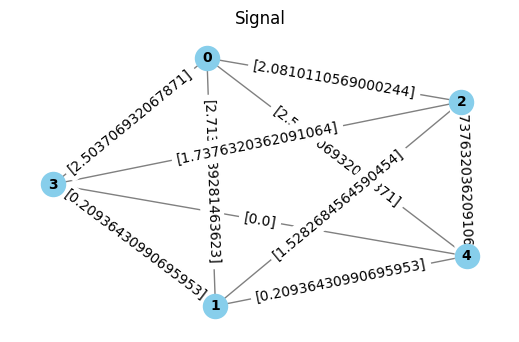

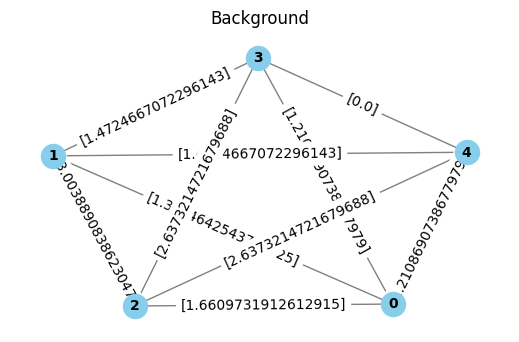

In [28]:
def visualize_graph(data, title):
    """
    Visualize a graph using networkx and matplotlib.
    
    Parameters:
    -----------
    data : Data
        A PyTorch Geometric Data object containing the graph to be visualized.
    """
    G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])

    
    plt.figure(figsize=(5, 3))
    
    pos = nx.spring_layout(G)  # Layout for positioning nodes
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

    edge_labels = nx.get_edge_attributes(G, 'edge_attr')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(title)
    plt.show()


visualize_graph(signal_pyg_graphs[0], 'Signal')
visualize_graph(background_pyg_graphs[0], 'Background')

## Model 4 Best

In [43]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features, num_hidden_graph_features):
        """
        GCN architecture for graph classification.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        self.classify = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim + num_hidden_graph_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, 1)
        )

        self.graph_features_nn = torch.nn.Sequential(
            torch.nn.Linear(num_graph_features, 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.7),
            torch.nn.Linear(16, num_hidden_graph_features)
        )


        ############### Model 4 - Best
        self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)
        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 64),
             torch.nn.ReLU(),
             torch.nn.Linear(64, hidden_dim * hidden_dim)
        )
        
        self.conv1 = NNConv(hidden_dim, hidden_dim, nn = self.edge_nn, aggr='max')
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = CGConv((hidden_dim, hidden_dim), aggr = 'mean')
        self.conv4 = GMMConv(hidden_dim, hidden_dim, dim=1, kernel_size=5)
        self.global_mean_pool_hook = global_mean_pool
        

    def forward(self, data):
        """
        Forward pass of the GCN model.

        Parameters:
        -----------
        data : Data
            PyTorch Geometric Data object containing graph and its features.

        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities for the graph labels.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # GCN layers
        x = F.relu(self.lin0(x))
        # x = F.relu(self.conv1(x, edge_index, edge_attr))
        # x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.conv4(x, edge_index, edge_attr))
        
        x = self.global_mean_pool_hook(x, data.batch)  # Shape: (batch_size, hidden_dim)
        self.global_embedding = x

        graph_features = torch.cat([data.jet_multiplicity.view(-1, 1), data.inv_mass.view(-1, 1)], dim=1)
        x = torch.cat([x, self.graph_features_nn(graph_features)], dim=1)
        
        # Fully connected layers
        x = self.classify(x)
        x = torch.sigmoid(x) 

        return x


# Training and Evaluation Routines

In [44]:
def train(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation loop
def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data).squeeze()
        pred = (out > 0.5).float()
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

## Network Training

In [45]:
model = GCNClassifier(num_node_features=4, num_edge_features = 1, hidden_dim=16, num_graph_features=2, num_hidden_graph_features = 1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad = False)
criterion = torch.nn.BCELoss()

EPOCHS = 250
training_loss = []
test_accuracy = []

with tqdm(total=EPOCHS, desc="Training Progress", leave=True) as pbar:
    for epoch in range(EPOCHS):
        loss = train(model, train_loader)
        acc = test(model, test_loader)
        training_loss.append(loss)
        test_accuracy.append(acc)

        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Accuracy': f'{acc:.4f}'})
        pbar.update(1)

Training Progress: 100%|██████████| 250/250 [01:01<00:00,  4.06it/s, Loss=0.4197, Accuracy=0.8041]


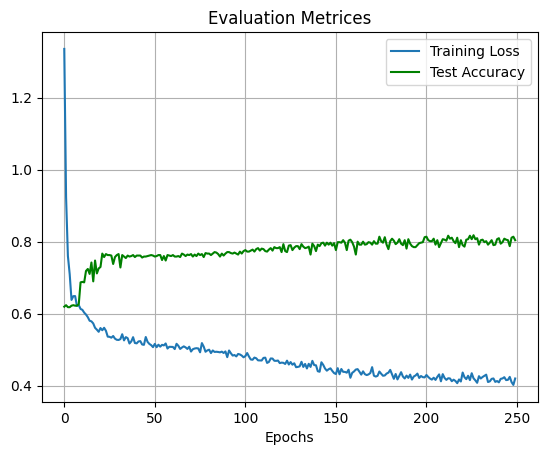

In [46]:
plt.plot([epoch for epoch in range(EPOCHS)], training_loss, label = 'Training Loss')
plt.plot([epoch for epoch in range(EPOCHS)], test_accuracy, color = 'g', label = 'Test Accuracy')
plt.legend()
plt.title('Evaluation Metrices')
plt.xlabel('Epochs')
plt.grid(which = 'both')
#plt.savefig('94auc.png', dpi=200)
plt.show()

y_true = []
y_pred_prob = []
for _, graph in enumerate(dataset):
    y_true.append(graph.y.numpy()[0])
    out = model(graph).squeeze().detach().numpy()
    y_pred_prob.append(float(out))
y_true, y_pred_prob = np.array(y_true), np.array(y_pred_prob)
y_pred_labels = (y_pred_prob > 0.5)

LR+: 5.216
LR-: 0.280
Accuracy: 0.820
Precision: 0.751
Recall: 0.761
F1-Score: 0.756


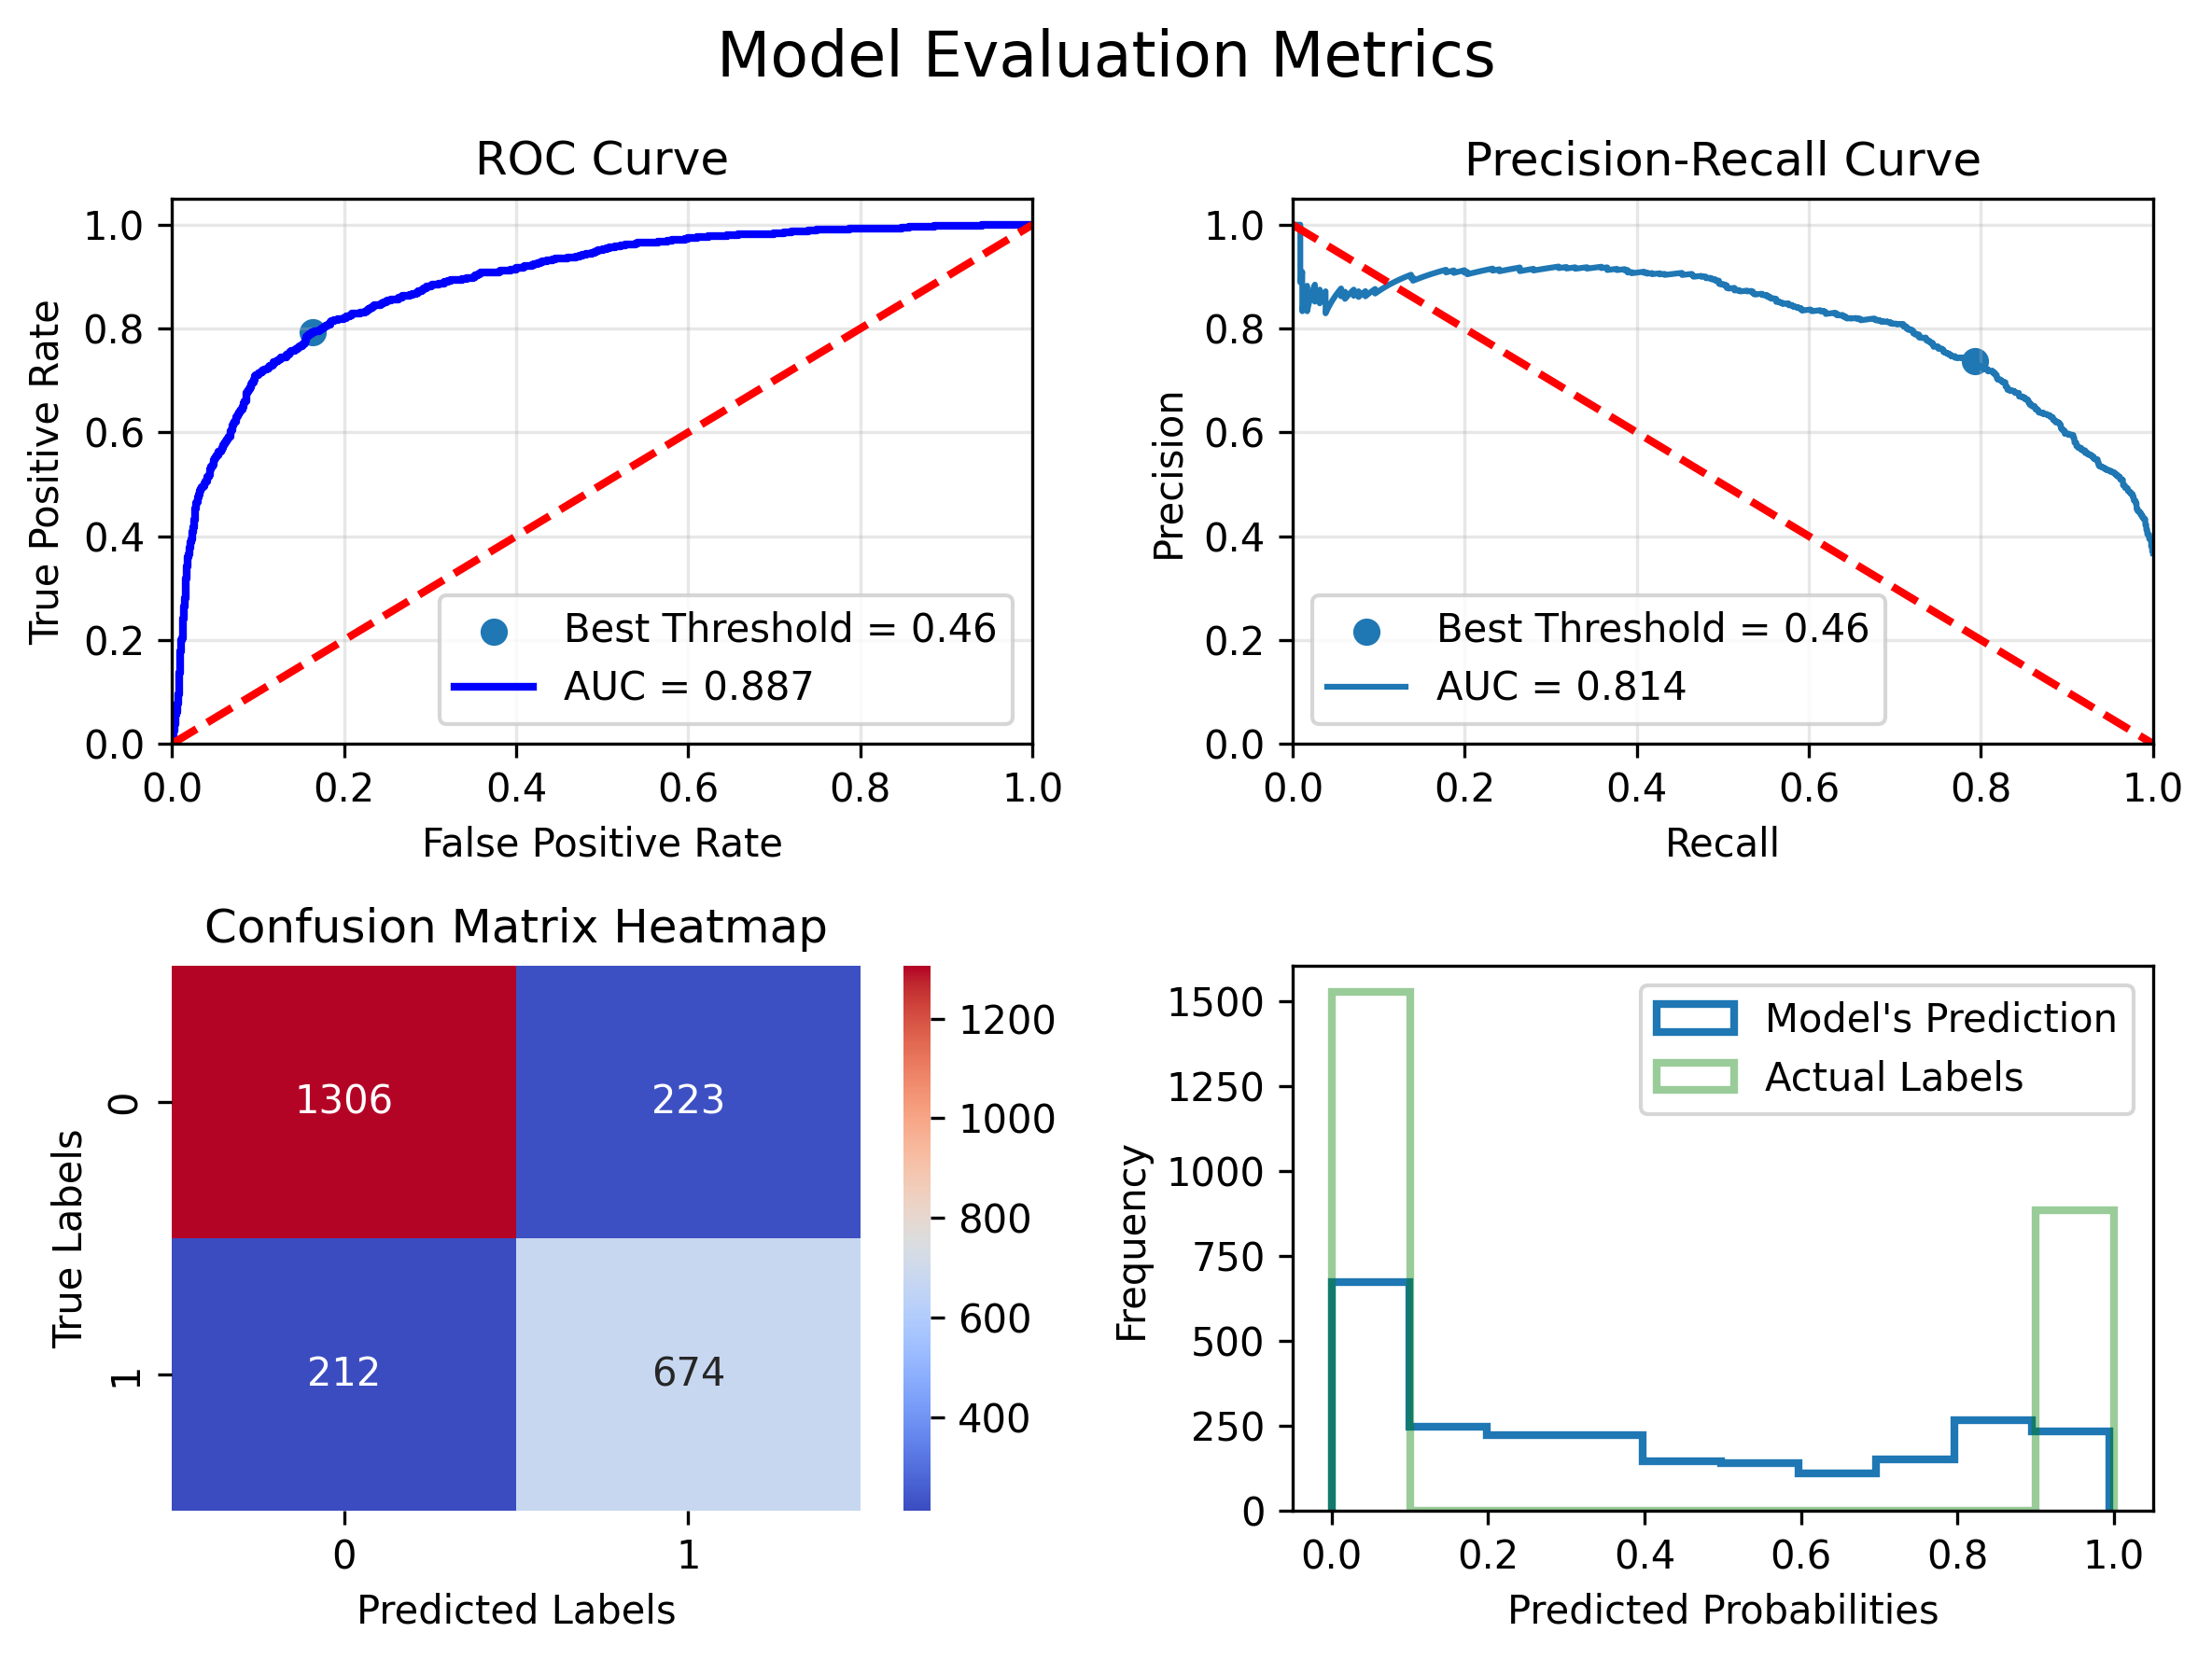

In [47]:
from helper_function_module import eval_model
eval_model(y_true, y_pred_prob, y_pred_labels)

In [ ]:
# np.save('NNConv_main_model', np.vstack((y_true, y_pred_prob)))
# torch.save(model, 'NNConv_main_model.pth')

# Extracting Graph Embedding from the Model

In [ ]:
def get_graph_embeddings():
    graph_embeddings = []
    def hook_fn(module, input, output):
        graph_embeddings.append(module.global_embedding.detach().cpu())
        
    
    model = GCNClassifier(num_node_features=6, num_edge_features=1, hidden_dim=49, 
                          num_graph_features=2, num_hidden_graph_features=1)
    
    handle = model.register_forward_hook(hook_fn)
    
    dataset_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    y_true_label = []
    y_pred_proba = []
    with torch.no_grad():
        for data in dataset_loader:
            y_true_label.extend(data.y.numpy())
            out = model(data)
            y_pred_proba.extend(out.numpy())
    
    handle.remove()
    graph_embedding_temp = []
    for tensor in graph_embeddings:
        graph_embedding_temp.extend(tensor.numpy())

    graph_embedding_temp = np.array(graph_embedding_temp).reshape((2415, 49))
    embedding_df = pd.DataFrame(graph_embedding_temp)
    embedding_df['true_label'] = y_true_label
    embedding_df['pred_prob'] = y_pred_proba
    embedding_df['pred_prob'] = embedding_df['pred_prob'].astype(float)

    return embedding_df

In [ ]:
# embedding_df = get_graph_embeddings()